## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

## Weight Function

In [2]:
# Function to calculate weights for LOWESS
def get_weights(X, xq, sig):
    m = X.shape[0]
    W = np.zeros((m, m))
    for i in range(m):
        W[i, i] = np.exp((-(X[i] - xq) ** 2) / (2* sig ** 2))
    return W

## Lowess Function

In [3]:
# LOWESS function
def lowess(X, y, frac):
    # Generate query points based on the range of X
    x_test = np.linspace(X.min(), X.max(), 20).reshape(-1, 1) 
    m = X.shape[0] 
    y_pred = np.zeros(x_test.shape[0]) 
    for i in range(x_test.shape[0]):
        W = get_weights(X, x_test[i], frac*m)
        theta = inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(y)
        y_pred[i] = x_test[i].dot(theta)
    return x_test, y_pred

## Preparing Dataset

In [4]:
# Load the dataset from the provided CSV file
file_path = 'full data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Clean up the 'Land Price (GHS)' column by removing commas and converting to float
data['Land Price (GHS)'] = data['Land Price (GHS)'].replace({',': ''}, regex=True).astype(float)

# Simulate a non-linear version of the dataset
np.random.seed(42)

# Number of samples
num_samples = len(data)

# Simulate the "Size of Plot" feature
size_of_plot = np.random.uniform(100, 600, num_samples)

# Simulate "Distance from Airport" and "Proximity to Main Road" with some randomness
distance_from_airport = np.random.uniform(5, 30, num_samples)
proximity_to_main_road = np.random.uniform(1, 10, num_samples)
proximity_to_city_center = np.random.uniform(5, 25, num_samples)

# Introduce non-linearity in "Land Price"
land_price = (size_of_plot ** 1.2) + (distance_from_airport ** 0.5) * 1000 - (proximity_to_main_road ** 2) * 50 + np.random.normal(0, 2000, num_samples)

# Create a DataFrame for the simulated data
simulated_data = pd.DataFrame({
    'Size of Plot (sq. meters)': size_of_plot,
    'Distance from Airport (km)': distance_from_airport,
    'Proximity to Main Road (km)': proximity_to_main_road,
    'Proximity to City Center (km)': proximity_to_city_center,
    'Land Price (GHS)': land_price
})

   Size of Plot (sq. meters)  Distance from Airport (km)  \
0                        250                        12.5   
1                        300                        15.0   
2                        150                         8.0   
3                        400                        10.0   
4                        500                        20.0   

   Proximity to Main Road (km)  Proximity to City Center (km) Land Price (GHS)  
0                          5.0                           20.0           25,000  
1                          3.0                           18.0           28,500  
2                          7.5                           25.0           15,750  
3                          4.0                           12.0           36,000  
4                          2.0                           10.0           45,500  


In [5]:
# Prepare data for LOWESS
X = simulated_data[['Size of Plot (sq. meters)']].values
y = simulated_data['Land Price (GHS)'].values

## Setting parameters and lowess graph

C:\Users\Ansah\AppData\Local\Temp\ipykernel_21244\2266599786.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i, i] = np.exp((-(X[i] - xq) ** 2) / (2* sig ** 2))


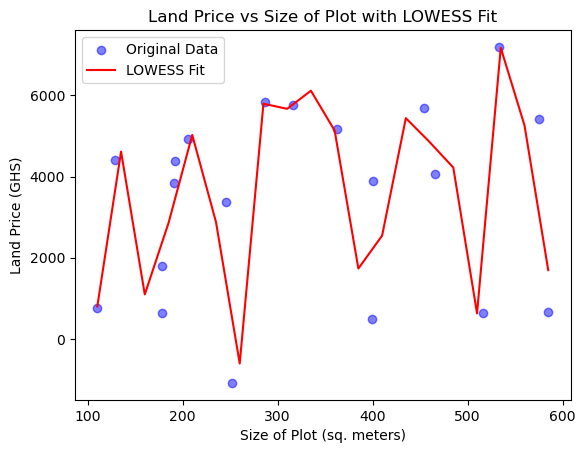

In [6]:
# Set the bandwidth parameter to perform LOWESS
frac = 0.3
# Perform LOWESS
x_smooth, y_smooth = lowess(X, y, frac)

# Plot the original data points
plt.scatter(X, y, color='blue', alpha=0.5, label='Original Data')

# Plot the LOWESS smoothed curve
plt.plot(x_smooth, y_smooth, color='red', label='LOWESS Fit')

# Add labels and title
plt.xlabel("Size of Plot (sq. meters)")
plt.ylabel("Land Price (GHS)")
plt.title("Land Price vs Size of Plot with LOWESS Fit")
plt.legend()

# Show the plot
plt.show()

## Analyzing bandwidth

C:\Users\Ansah\AppData\Local\Temp\ipykernel_21244\2266599786.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i, i] = np.exp((-(X[i] - xq) ** 2) / (2* sig ** 2))


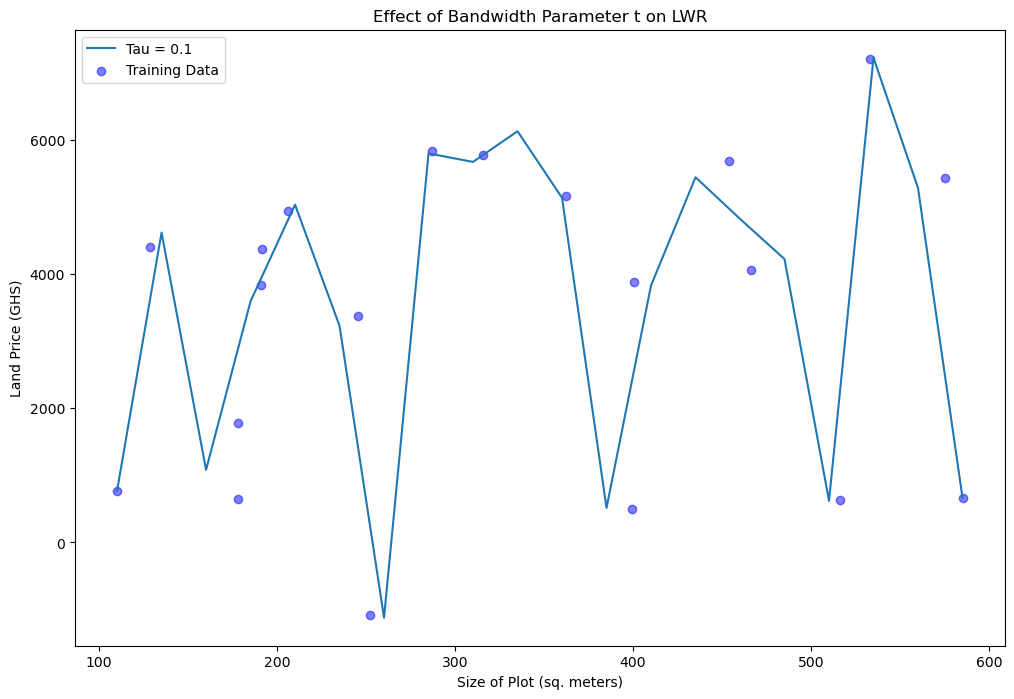

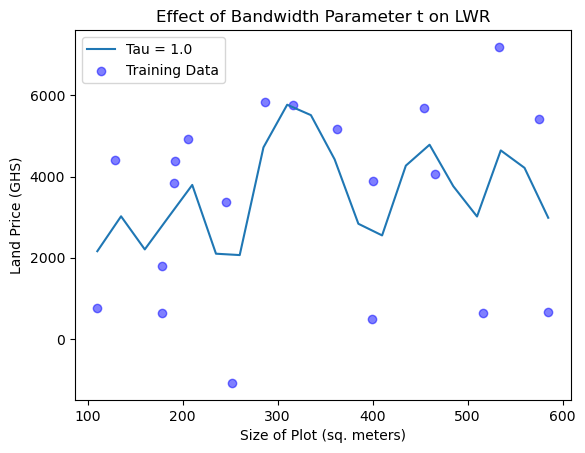

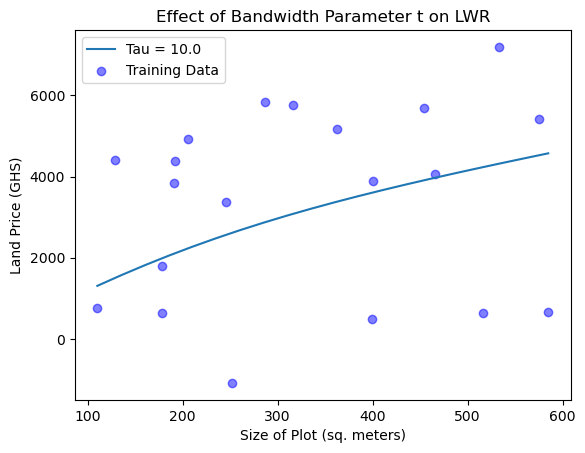

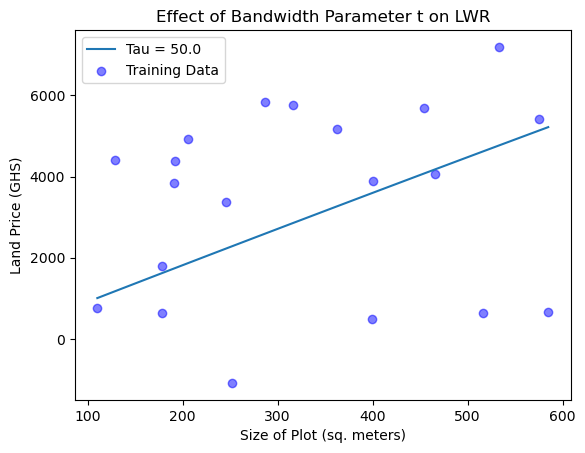

In [7]:
tau_values = [0.1, 1.0, 10.0, 50.0]
plt.figure(figsize=(12, 8))

for tau in tau_values:
    query, pred = lowess(X, y, tau)
    plt.plot(query, pred, label=f'Tau = {tau}')

    plt.scatter(X, y, color='blue', label='Training Data', alpha=0.5)
    plt.title('Effect of Bandwidth Parameter t on LWR')
    plt.xlabel('Size of Plot (sq. meters)')
    plt.ylabel('Land Price (GHS)')
    plt.legend()
    plt.show()

In Locally Weighted Regression (LWR), the parameter(t) controls the width of the weight function, affecting how much influence neighbouring points have on the prediction. The parameter essentially determines how localized the model is.

- **When t is small (t = 0.1 ):** The model heavily weights points that are very close to the query point. This means the predictions are strongly influenced by nearby data points, resulting in high variance and a tendency to overfit the data. This can be observed in the graph as the regression line fits tightly to the points, following noise or small fluctuations in the data.
  
- **When t is large (tau = 50):** The weight function becomes broader and points farther from the query point have a more significant influence. As a result, the regression line becomes smoother and less sensitive to individual points. This can lead to underfitting, where the model captures only general trends and may miss important local variations, as seen in the graph where the line is more general and less adapted to the data points.

From the graphs, it is clear that:

- **Lower t** values cause overfitting as the line adheres too closely to the data points.
- **Higher t** values cause underfitting as the line becomes too smooth and doesn't capture the local structure of the data. 